# Random forest model to predict price of bulldozers

This is a part of the fast.ai course where we are using a simple random forest algorightm to solve the kaggle challenge -
[Blue book for bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

%matplotlib inline
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [2]:
raw_data = pd.read_csv('bulldozers_train_data.csv', low_memory=False, parse_dates=['saledate'])

In [3]:
raw_data.head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DATA EXPLORATION

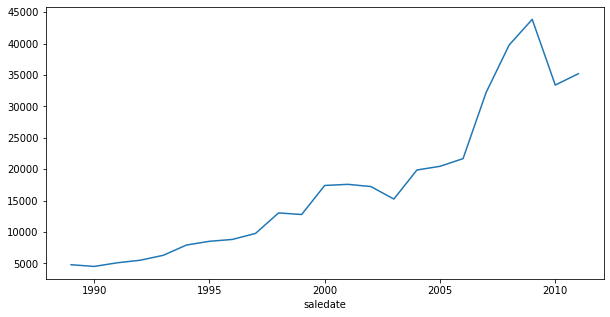

In [4]:
## plot sales per year
fig, ax = plt.subplots(figsize=(10,5))
raw_data.groupby(raw_data['saledate'].dt.year)['SalePrice'].count().plot(ax=ax)

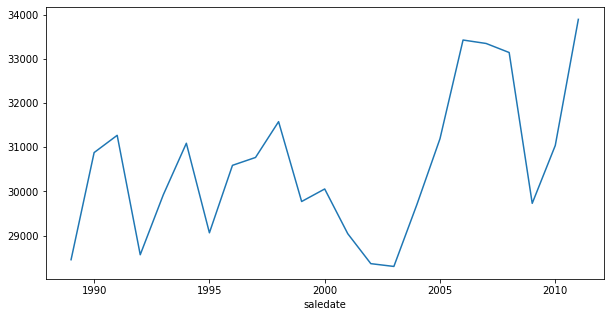

In [5]:
## plot sales number per year
fig, ax = plt.subplots(figsize=(10,5))
raw_data.groupby(raw_data['saledate'].dt.year)['SalePrice'].mean().plot(ax=ax)

In [6]:
## shape
raw_data.shape

(401125, 53)

## FEATURE ENGINEERING (for entire dataset)

In [7]:
# transform the sale price to log data
raw_data['SalePrice'] = np.log(raw_data['SalePrice'])

In [8]:
# feature engineering for the dates
def add_datepart(df, fldname):
    fld = df[fldname]
    target_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end'
             , 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        
        df[target_pre+n] = getattr(fld.dt, n.lower())
    df[target_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)
    return df

In [9]:
# convert non numeric values to categories
def numericalize(df, col, name):
    if not pd.api.types.is_numeric_dtype(col):
        col = col.astype('category')
        df[name] = col.cat.codes+1

In [10]:
# fill missing variables
def fill_missing_vals(df, fill_strategy):
    imp = SimpleImputer(missing_values=np.nan, strategy=fill_strategy)
    imp.fit(df)
    raw_data_columns = df.columns
    df_temp = imp.transform(df)
    cleaned_data = pd.DataFrame(df_temp, columns=raw_data_columns)
    cleaned_data = cleaned_data.reset_index(drop=True)
    return cleaned_data

In [11]:
# add date part
raw_data = add_datepart(raw_data, 'saledate')

# convert usage band to ordinal type
raw_data['UsageBand'].astype('category').cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

# numericalize columns
for n, c in raw_data.items():
    if n == 'SalePrice':
        continue
    #print(f"processing column {n}")
    numericalize(raw_data, c, n)
    
#fill missing values
cleaned_data = fill_missing_vals(raw_data, 'median')

In [12]:
cleaned_data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246.0,11.097410,999089.0,3157.0,121.0,3.0,2004.0,68.0,2.0,950.0,296.0,41.0,0.0,0.0,0.0,59.0,1.0,6.0,6.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2006.0,11.0,46.0,16.0,3.0,320.0,0.0,0.0,0.0,0.0,0.0,0.0,6512.0
1,1139248.0,10.950807,117657.0,77.0,121.0,3.0,1996.0,4640.0,2.0,1725.0,527.0,55.0,98.0,0.0,4.0,62.0,33.0,6.0,6.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2004.0,3.0,13.0,26.0,4.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,5547.0
2,1139249.0,9.210340,434808.0,7009.0,121.0,3.0,2001.0,2838.0,1.0,331.0,110.0,0.0,0.0,0.0,0.0,39.0,32.0,3.0,3.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,2.0,9.0,26.0,3.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,5518.0
3,1139251.0,10.558414,1026470.0,332.0,121.0,3.0,2001.0,3486.0,1.0,3674.0,1375.0,0.0,45.0,0.0,6.0,8.0,44.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,5.0,20.0,19.0,3.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,8157.0
4,1139253.0,9.305651,1057373.0,17311.0,121.0,3.0,2007.0,722.0,3.0,4208.0,1529.0,0.0,0.0,0.0,0.0,40.0,32.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009.0,7.0,30.0,23.0,3.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,7492.0


### split into train test dataset

In [13]:
## split data into training and validation set
## we want to keep the latest data for the test set hence we 
## sort the values before splitting the dataset manually
cleaned_data.sort_values(by=['saleYear', 'saleMonth', 'saleDay'], inplace=True, ascending=True)

test_set_len = round(cleaned_data.shape[0]*0.05)
train_set_len = cleaned_data.shape[0] - test_set_len

def split_data(df, lenth_of_split):
    return df[:lenth_of_split], df[lenth_of_split:]

train_df, test_df = split_data(cleaned_data, train_set_len)

In [14]:
# get X_train, y_train, X_test, y_test
y_train = train_df['SalePrice'].values
X_train = train_df.drop(['SalePrice'], axis=1)

y_test = test_df['SalePrice'].values
X_test = test_df.drop(['SalePrice'], axis=1)

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(381069, 64) (381069,) (20056, 64) (20056,)


### modelling

In [16]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=30, max_features=0.5)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
# score the test set data
m.score(X_test, y_test)

0.8852071895789733

In [18]:
# get the RMLSE
mean_squared_error(y_test, m.predict(X_test), squared=False)

0.2422578213234652

## RF exploration

In [19]:
# explore the prediction of each tree and find the mean
preds = np.stack([t.predict(X_test) for t in m.estimators_])
print(np.mean(preds[:, 0]))
print(y_test[0])

9.604102515729734
9.852194258148577


In [20]:
m.predict(X_test)[0]

9.604102515729737

In [21]:
preds.shape

(30, 20056)

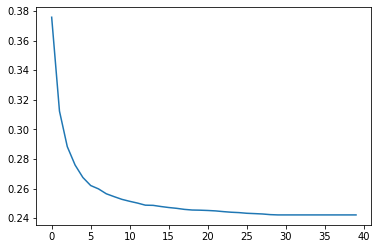

In [22]:
plt.plot([mean_squared_error(y_test, np.mean(preds[:i+1], axis=0), squared=False) for i in range(40)])

Here we can see that the mean squared error seems to have stabilised at around 35 trees. So we should keep the number of trees
(the `n_estimator` parameter) in the Random Forest model to 35 to prevent overfitting)

#### Feature Importances

In [23]:
## get feature importances
importances = m.feature_importances_
importances

array([3.14521136e-02, 2.01795591e-02, 5.70623786e-02, 1.15587959e-03,
       4.58244173e-03, 1.64713970e-01, 2.50116495e-03, 9.24458973e-04,
       3.06874021e-02, 2.40843756e-02, 4.71719852e-02, 4.30545139e-03,
       2.44105024e-02, 9.46597015e-02, 6.60260708e-02, 7.72947816e-03,
       1.01805714e-02, 4.85621516e-03, 8.85245339e-03, 4.17238021e-02,
       9.51242389e-04, 1.77902973e-03, 6.95060076e-04, 2.27737439e-03,
       1.37203455e-03, 2.39362898e-03, 1.47652766e-04, 2.91227506e-04,
       2.58436501e-03, 9.39840096e-04, 1.00805877e-02, 1.70412791e-03,
       3.63095612e-03, 4.22735315e-04, 1.29954809e-03, 1.06877329e-02,
       1.28583536e-03, 9.42270187e-02, 4.47997214e-02, 5.43727663e-02,
       2.70884295e-03, 1.08090362e-03, 3.55336082e-03, 6.04397534e-04,
       3.40842141e-04, 5.00278453e-04, 4.48773143e-04, 2.63038960e-03,
       1.65615410e-03, 2.13316860e-04, 2.24951491e-04, 1.99131375e-02,
       2.88539848e-03, 5.41065769e-03, 7.40057294e-03, 4.02466411e-03,
      

### modeling version 2 - IMP features only

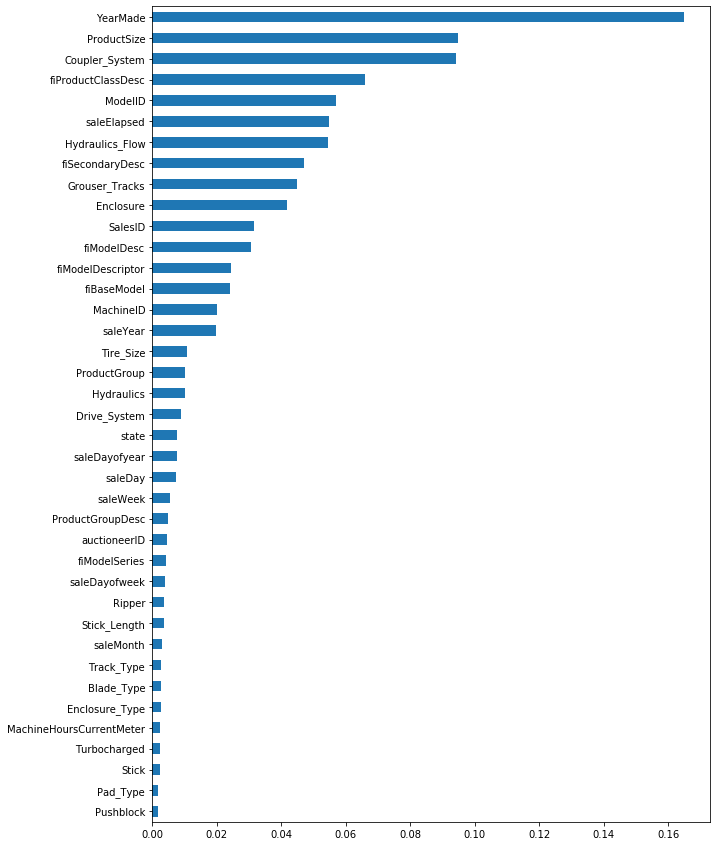

In [24]:
## plot feature importances
imp_series = pd.Series(m.feature_importances_, index=X_train.columns).sort_values()[25:]
imp_series.plot(kind='barh', figsize=(10,15), sort_columns=True)

We can remove the less important features to get a clean and lean feature set and make ensure the data has more signal than noise

In [25]:
## capturing only important features (features having importance as >= 0.02)
imp_only_columns = imp_series.where(imp_series >= 0.002).dropna().index.to_list()
imp_only_columns

['Stick',
 'Turbocharged',
 'MachineHoursCurrentMeter',
 'Enclosure_Type',
 'Blade_Type',
 'Track_Type',
 'saleMonth',
 'Stick_Length',
 'Ripper',
 'saleDayofweek',
 'fiModelSeries',
 'auctioneerID',
 'ProductGroupDesc',
 'saleWeek',
 'saleDay',
 'saleDayofyear',
 'state',
 'Drive_System',
 'Hydraulics',
 'ProductGroup',
 'Tire_Size',
 'saleYear',
 'MachineID',
 'fiBaseModel',
 'fiModelDescriptor',
 'fiModelDesc',
 'SalesID',
 'Enclosure',
 'Grouser_Tracks',
 'fiSecondaryDesc',
 'Hydraulics_Flow',
 'saleElapsed',
 'ModelID',
 'fiProductClassDesc',
 'Coupler_System',
 'ProductSize',
 'YearMade']

In [26]:
X_train_imp_cols = X_train[imp_only_columns]
X_test_imp_cols = X_test[imp_only_columns]

In [27]:
print(X_train_imp_cols.shape, y_train.shape, X_test_imp_cols.shape, y_test.shape)

(381069, 37) (381069,) (20056, 37) (20056,)


#### retrain the model on important features only

In [28]:
## retraining the model with only important columns
m1 = RandomForestRegressor(n_jobs=-1, n_estimators=30, max_features=0.5)
m1.fit(X_train_imp_cols, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
# score
m1.score(X_test_imp_cols, y_test)

0.8843502224914048

In [30]:
# get the RMLSE
mean_squared_error(y_test, m1.predict(X_test_imp_cols), squared=False)

0.24316040814198123

In [31]:
## get feature importances
importances = m1.feature_importances_
importances

array([0.00151675, 0.00109567, 0.00294666, 0.00285623, 0.00516351,
       0.00657723, 0.00309285, 0.00509131, 0.0041073 , 0.00426614,
       0.00504212, 0.0048625 , 0.00347501, 0.00577071, 0.00796849,
       0.00806848, 0.0081627 , 0.01290419, 0.00965402, 0.00347473,
       0.01287778, 0.0216323 , 0.02115342, 0.0201606 , 0.03262691,
       0.03457145, 0.03157131, 0.02992447, 0.03354212, 0.04857249,
       0.07348584, 0.05460506, 0.05392235, 0.08199821, 0.08908389,
       0.08869434, 0.16548086])

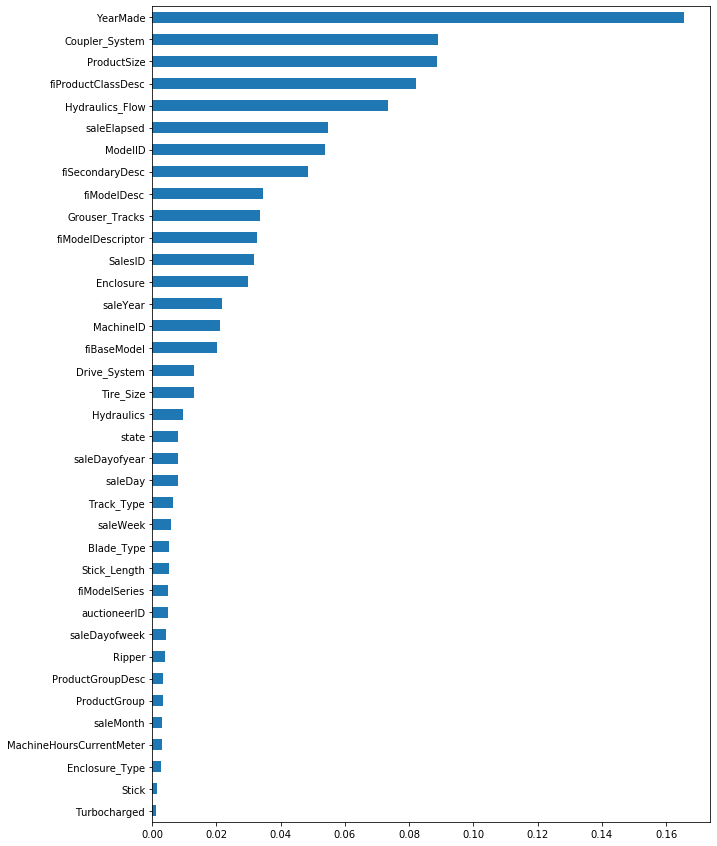

In [32]:
## get feature importances of new model
## plot feature importances
imp_series = pd.Series(m1.feature_importances_, index=X_train_imp_cols.columns).sort_values()
imp_series.plot(kind='barh', figsize=(10,15), sort_columns=True)

From this we can observe that feature importance has changed with year made and coupler systems being the most important fetures when predicting the sale price

### modelling v3 - imp features + one hot encoded columns

In [33]:
# add function for one hot encoding
def one_hot_encode_df(raw_data):
    for colname, col in raw_data.items():
        if not pd.api.types.is_numeric_dtype(col) and raw_data[colname].nunique() <= 7:
            print(f"processing column {colname}")
            oneHotEncoded = pd.get_dummies(raw_data[colname], prefix=colname, dummy_na=True)
            #raw_data.drop(colname, axis=1, inplace = True)
            raw_data = pd.concat([raw_data, oneHotEncoded], axis=1)
    return raw_data

We re-ingest the data and perform one hot encoding on select variables (where the number of unique values in the column is =< 7) to have more features and see if one feature/value of feautre holds more importance

In [34]:
raw_data = pd.read_csv('bulldozers_train_data.csv', low_memory=False, parse_dates=['saledate'])

In [35]:
# transform the sale price to log data
raw_data['SalePrice'] = np.log(raw_data['SalePrice'])

# add date part
raw_data = add_datepart(raw_data, 'saledate')

# keep only imp columns
raw_data = raw_data[imp_only_columns+['SalePrice']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002050DEBB088>]],
      dtype=object)

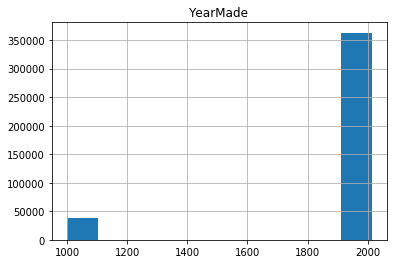

In [36]:
#explore the year made column
raw_data.hist(column='YearMade')

We can see that a lot of records have a YearMade value in year 1000. We will assume they were all manufactured in 1950

In [37]:
print(f"count of rows : {raw_data['YearMade'].count()}")
print(f"count of null values: {raw_data['YearMade'].isnull().values.sum()}")

count of rows : 401125
count of null values: 0


In [38]:
raw_data.loc[raw_data['YearMade'] < 1950, 'YearMade'] = 1950

In [39]:
# one hot encode raw data
raw_data = one_hot_encode_df(raw_data)

processing column Stick
processing column Turbocharged
processing column Enclosure_Type
processing column Track_Type
processing column Ripper
processing column ProductGroupDesc
processing column Drive_System
processing column ProductGroup
processing column Enclosure
processing column Grouser_Tracks
processing column Hydraulics_Flow
processing column Coupler_System
processing column ProductSize


In [40]:
# convert non numeric values to categories
for n, c in raw_data.items():
    if n == 'SalePrice':
        continue
    #print(f"processing column {n}")
    numericalize(raw_data, c, n)

In [41]:
# fill missing variables
cleaned_data = fill_missing_vals(raw_data, 'median')

In [42]:
cleaned_data.columns

Index(['Stick', 'Turbocharged', 'MachineHoursCurrentMeter', 'Enclosure_Type',
       'Blade_Type', 'Track_Type', 'saleMonth', 'Stick_Length', 'Ripper',
       'saleDayofweek', 'fiModelSeries', 'auctioneerID', 'ProductGroupDesc',
       'saleWeek', 'saleDay', 'saleDayofyear', 'state', 'Drive_System',
       'Hydraulics', 'ProductGroup', 'Tire_Size', 'saleYear', 'MachineID',
       'fiBaseModel', 'fiModelDescriptor', 'fiModelDesc', 'SalesID',
       'Enclosure', 'Grouser_Tracks', 'fiSecondaryDesc', 'Hydraulics_Flow',
       'saleElapsed', 'ModelID', 'fiProductClassDesc', 'Coupler_System',
       'ProductSize', 'YearMade', 'SalePrice', 'Stick_Extended',
       'Stick_Standard', 'Stick_nan', 'Turbocharged_None or Unspecified',
       'Turbocharged_Yes', 'Turbocharged_nan', 'Enclosure_Type_High Profile',
       'Enclosure_Type_Low Profile', 'Enclosure_Type_None or Unspecified',
       'Enclosure_Type_nan', 'Track_Type_Rubber', 'Track_Type_Steel',
       'Track_Type_nan', 'Ripper_Multi Shank

In [43]:
## split data into training and validation set
## we want to keep the latest data for the test set hence we 
## sort the values before splitting the dataset manually
cleaned_data.sort_values(by=['saleYear', 'saleMonth', 'saleDay'], inplace=True, ascending=True)

test_set_len = round(cleaned_data.shape[0]*0.05)
train_set_len = cleaned_data.shape[0] - test_set_len

def split_data(df, lenth_of_split):
    return df[:lenth_of_split], df[lenth_of_split:]

train_df, test_df = split_data(cleaned_data, train_set_len)

In [44]:
train_df.shape

(381069, 99)

In [45]:
test_df.shape

(20056, 99)

In [46]:
# get X_train, y_train, X_test, y_test
y_train2 = train_df['SalePrice'].values
X_train2 = train_df.drop(['SalePrice'], axis=1)

y_test2 = test_df['SalePrice'].values
X_test2 = test_df.drop(['SalePrice'], axis=1)

In [47]:
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

(381069, 98) (381069,) (20056, 98) (20056,)


In [48]:
X_train2.head()

,Stick,Turbocharged,MachineHoursCurrentMeter,Enclosure_Type,Blade_Type,Track_Type,saleMonth,Stick_Length,Ripper,saleDayofweek,fiModelSeries,auctioneerID,ProductGroupDesc,saleWeek,saleDay,saleDayofyear,state,Drive_System,Hydraulics,ProductGroup,Tire_Size,saleYear,MachineID,fiBaseModel,fiModelDescriptor,fiModelDesc,SalesID,Enclosure,Grouser_Tracks,fiSecondaryDesc,Hydraulics_Flow,saleElapsed,ModelID,fiProductClassDesc,Coupler_System,ProductSize,YearMade,Stick_Extended,Stick_Standard,Stick_nan,Turbocharged_None or Unspecified,Turbocharged_Yes,Turbocharged_nan,Enclosure_Type_High Profile,Enclosure_Type_Low Profile,Enclosure_Type_None or Unspecified,Enclosure_Type_nan,Track_Type_Rubber,Track_Type_Steel,Track_Type_nan,Ripper_Multi Shank,Ripper_None or Unspecified,Ripper_Single Shank,Ripper_Yes,Ripper_nan,ProductGroupDesc_Backhoe Loaders,ProductGroupDesc_Motor Graders,ProductGroupDesc_Skid Steer Loaders,ProductGroupDesc_Track Excavators,ProductGroupDesc_Track Type Tractors,ProductGroupDesc_Wheel Loader,ProductGroupDesc_nan,Drive_System_All Wheel Drive,Drive_System_Four Wheel Drive,Drive_System_No,Drive_System_Two Wheel Drive,Drive_System_nan,ProductGroup_BL,ProductGroup_MG,ProductGroup_SSL,ProductGroup_TEX,ProductGroup_TTT,ProductGroup_WL,ProductGroup_nan,Enclosure_EROPS,Enclosure_EROPS AC,Enclosure_EROPS w AC,Enclosure_NO ROPS,Enclosure_None or Unspecified,Enclosure_OROPS,Enclosure_nan,Grouser_Tracks_None or Unspecified,Grouser_Tracks_Yes,Grouser_Tracks_nan,Hydraulics_Flow_High Flow,Hydraulics_Flow_None or Unspecified,Hydraulics_Flow_Standard,Hydraulics_Flow_nan,Coupler_System_None or Unspecified,Coupler_System_Yes,Coupler_System_nan,ProductSize_Compact,ProductSize_Large,ProductSize_Large / Medium,ProductSize_Medium,ProductSize_Mini,ProductSize_Small,ProductSize_nan
205615,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,2.0,1.0,0.0,18.0,5.0,3.0,17.0,17.0,44.0,0.0,1.0,5.0,0.0,1989.0,1126363.0,1735.0,0.0,4537.0,1646770.0,6.0,0.0,0.0,0.0,0.0,8434.0,47.0,0.0,4.0,1974.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28603,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,18.0,1.0,5.0,31.0,31.0,10.0,4.0,0.0,1.0,0.0,1989.0,1292226.0,324.0,0.0,1047.0,1259551.0,6.0,0.0,0.0,0.0,14.0,6788.0,2.0,0.0,0.0,1977.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28757,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,99.0,1.0,5.0,31.0,31.0,9.0,4.0,0.0,1.0,0.0,1989.0,1476205.0,324.0,0.0,1047.0,1259760.0,6.0,0.0,0.0,0.0,14.0,6788.0,2.0,0.0,0.0,1978.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28820,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,18.0,1.0,5.0,31.0,31.0,10.0,4.0,0.0,1.0,0.0,1989.0,1226323.0,324.0,0.0,1047.0,1259842.0,6.0,0.0,0.0,0.0,14.0,6788.0,2.0,0.0,0.0,1978.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28927,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,18.0,1.0,5.0,31.0,31.0,10.0,4.0,0.0,1.0,0.0,1989.0,1150485.0,324.0,0.0,1047.0,1259973.0,6.0,0.0,0.0,0.0,14.0,6788.0,2.0,0.0,0.0,1978.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
## retraining the model with only important columns
m2 = RandomForestRegressor(n_jobs=-1, n_estimators=35, max_features=0.5)
m2.fit(X_train2, y_train2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=35, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
# score
m2.score(X_test2, y_test2)

0.8831375431610206

In [51]:
# get the RMLSE
mean_squared_error(y_test2, m2.predict(X_test2), squared=False)

0.24443194809957916

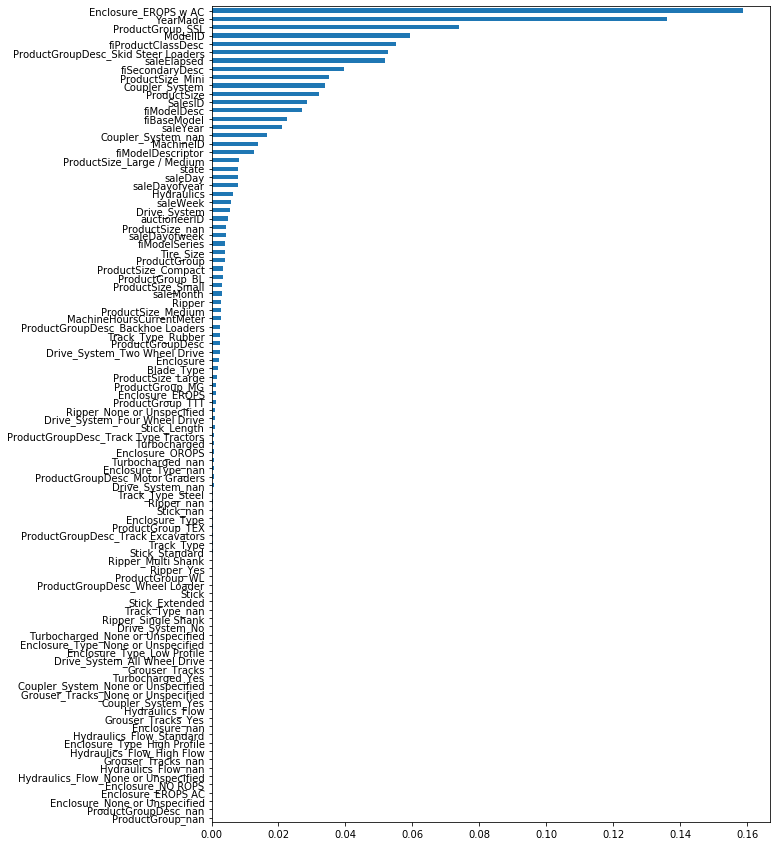

In [52]:
## get feature importances of new model
## plot feature importances
imp_series = pd.Series(m2.feature_importances_, index=X_train2.columns).sort_values()
imp_series.plot(kind='barh', figsize=(10,15), sort_columns=True)

### FINAL MODEL

In [53]:
# we will drop unique identifiers as they do not add any value in determining the sale value
X_train2.drop(['SalesID', 'MachineID'], axis=1, inplace=True)

In [58]:
## retraining the model with only important columns
m3 = RandomForestRegressor(n_jobs=-1, n_estimators=35, max_features=0.5)
m3.fit(X_train2, y_train2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=35, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [60]:
# score
X_test2.drop(['SalesID', 'MachineID'], axis=1, inplace=True)
m3.score(X_test2, y_test2)

0.8875165209956598

In [61]:
# get the RMLSE
mean_squared_error(y_test2, m3.predict(X_test2), squared=False)

0.23980864378016786

With this model, we can see that the score has increased slightly from 0.8852 to 0.8875
and the RMSLE has also improved from 0.242 to 0.239